In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:

# Load the CSV file
df = pd.read_csv("fpga_logs_consolidated.csv")

In [4]:
# Identify time-related columns (assuming they contain 'time' in their name, adjust if necessary)
time_columns = [col for col in df.columns if 'time' in col.lower()]

time_columns


['User Time', 'System Time', 'Elapsed Time']

In [5]:
import re

def convert_to_seconds(time_str):
    match = re.match(r'(?:(\d+)m )?(\d+\.\d+)s', time_str)
    if match:
        minutes = int(match.group(1)) if match.group(1) else 0
        seconds = float(match.group(2))
        return minutes * 60 + seconds
    else:
        return None

df['Elapsed Time'] = df['Elapsed Time'].apply(convert_to_seconds)

In [6]:
# Compute the average runtime for each (tool, routine) combination
average_df = df.groupby(["Benchmark", "Tool", "Routine"])[["User Time", "System Time", "Elapsed Time", "MAX RSS", "Minor Page Faults", "Voluntary Context Switches"]].mean().reset_index()

# Save the results to a new CSV file
average_df.to_csv("fpga_logs_averaged.csv", index=False)

print("Averaged data saved to fpga_logs_averaged.csv")

Averaged data saved to fpga_logs_averaged.csv


In [7]:
df = pd.read_csv("fpga_logs_averaged.csv")

df.head(10)

,Benchmark,Tool,Routine,User Time,System Time,Elapsed Time,MAX RSS,Minor Page Faults,Voluntary Context Switches
0,aha-mont64,dynamorio,BBCount,2.846,0.633,3.575,12427.2,611.8,1.0
1,aha-mont64,dynamorio,none,1.248,0.457,1.769,7648.0,412.6,1.0
2,aha-mont64,none,none,0.281,0.016,0.311,176.0,6.0,1.0
3,aha-mont64,rvisor,BBCount,9.472,0.060,9.560,2672.0,49.0,1.0
4,aha-mont64,rvisor,none,8.989,0.052,9.065,2656.0,48.0,1.0
5,aha-mont64,tlrvisor,BBCount,0.758,0.066,0.845,2832.0,58.0,1.0
6,aha-mont64,tlrvisor,none,0.634,0.058,0.710,2752.0,54.0,1.0
7,crc32,dynamorio,BBCount,2.732,0.603,3.434,12265.6,658.3,1.0
8,crc32,dynamorio,none,1.336,0.429,1.831,7616.0,395.6,1.0
9,crc32,none,none,0.250,0.015,0.286,176.0,6.0,1.0


In [8]:
# Filter the baseline cases
baseline_cases = average_df[(average_df['Tool'] == 'none') & (average_df['Routine'] == 'none')]

# Merge the average_df with the baseline cases to get the baseline values for each benchmark
relative_df = average_df.merge(baseline_cases, on='Benchmark', suffixes=('', '_baseline'))

# Calculate the relative values
norm_cols = ["User Time","System Time","Elapsed Time","MAX RSS","Minor Page Faults","Voluntary Context Switches"]
for col in norm_cols:
    relative_df[col] = relative_df[col] / relative_df[f'{col}_baseline']

# Drop the baseline columns
relative_df = relative_df.drop(columns=[f'{col}_baseline' for col in time_columns])

# Save the relative_df to a new CSV file
relative_df.to_csv("fpga_logs_relative.csv", index=False)

print("Relative data saved to fpga_logs_relative.csv")
relative_df.head(10)



Relative data saved to fpga_logs_relative.csv


,Benchmark,Tool,Routine,User Time,System Time,Elapsed Time,MAX RSS,Minor Page Faults,Voluntary Context Switches,Tool_baseline,Routine_baseline,MAX RSS_baseline,Minor Page Faults_baseline,Voluntary Context Switches_baseline
0,aha-mont64,dynamorio,BBCount,10.128114,39.5625,11.495177,70.609091,101.966667,1.0,none,none,176.0,6.0,1.0
1,aha-mont64,dynamorio,none,4.441281,28.5625,5.688103,43.454545,68.766667,1.0,none,none,176.0,6.0,1.0
2,aha-mont64,none,none,1.000000,1.0000,1.000000,1.000000,1.000000,1.0,none,none,176.0,6.0,1.0
3,aha-mont64,rvisor,BBCount,33.708185,3.7500,30.739550,15.181818,8.166667,1.0,none,none,176.0,6.0,1.0
4,aha-mont64,rvisor,none,31.989324,3.2500,29.147910,15.090909,8.000000,1.0,none,none,176.0,6.0,1.0
5,aha-mont64,tlrvisor,BBCount,2.697509,4.1250,2.717042,16.090909,9.666667,1.0,none,none,176.0,6.0,1.0
6,aha-mont64,tlrvisor,none,2.256228,3.6250,2.282958,15.636364,9.000000,1.0,none,none,176.0,6.0,1.0
7,crc32,dynamorio,BBCount,10.928000,40.2000,12.006993,69.690909,109.716667,1.0,none,none,176.0,6.0,1.0
8,crc32,dynamorio,none,5.344000,28.6000,6.402098,43.272727,65.933333,1.0,none,none,176.0,6.0,1.0
9,crc32,none,none,1.000000,1.0000,1.000000,1.000000,1.000000,1.0,none,none,176.0,6.0,1.0


In [9]:
selected_columns_df = relative_df[['Benchmark', 'Tool', 'Routine', 'Elapsed Time']]

In [10]:
# Sort by Elapsed Time for each Benchmark
sorted_df = selected_columns_df.sort_values(by=['Benchmark', 'Elapsed Time'])

# Save the sorted dataframe to a new CSV file
sorted_df.to_csv("benchmark_tool_routine_elapsed_time_sorted.csv", index=False)

print("Data saved to benchmark_tool_routine_elapsed_time_sorted.csv")

Data saved to benchmark_tool_routine_elapsed_time_sorted.csv


In [11]:
rail_color = '#3F6BB9'
rail_plus_color = '#7DB958'
dynamorio_color = '#996CAB'

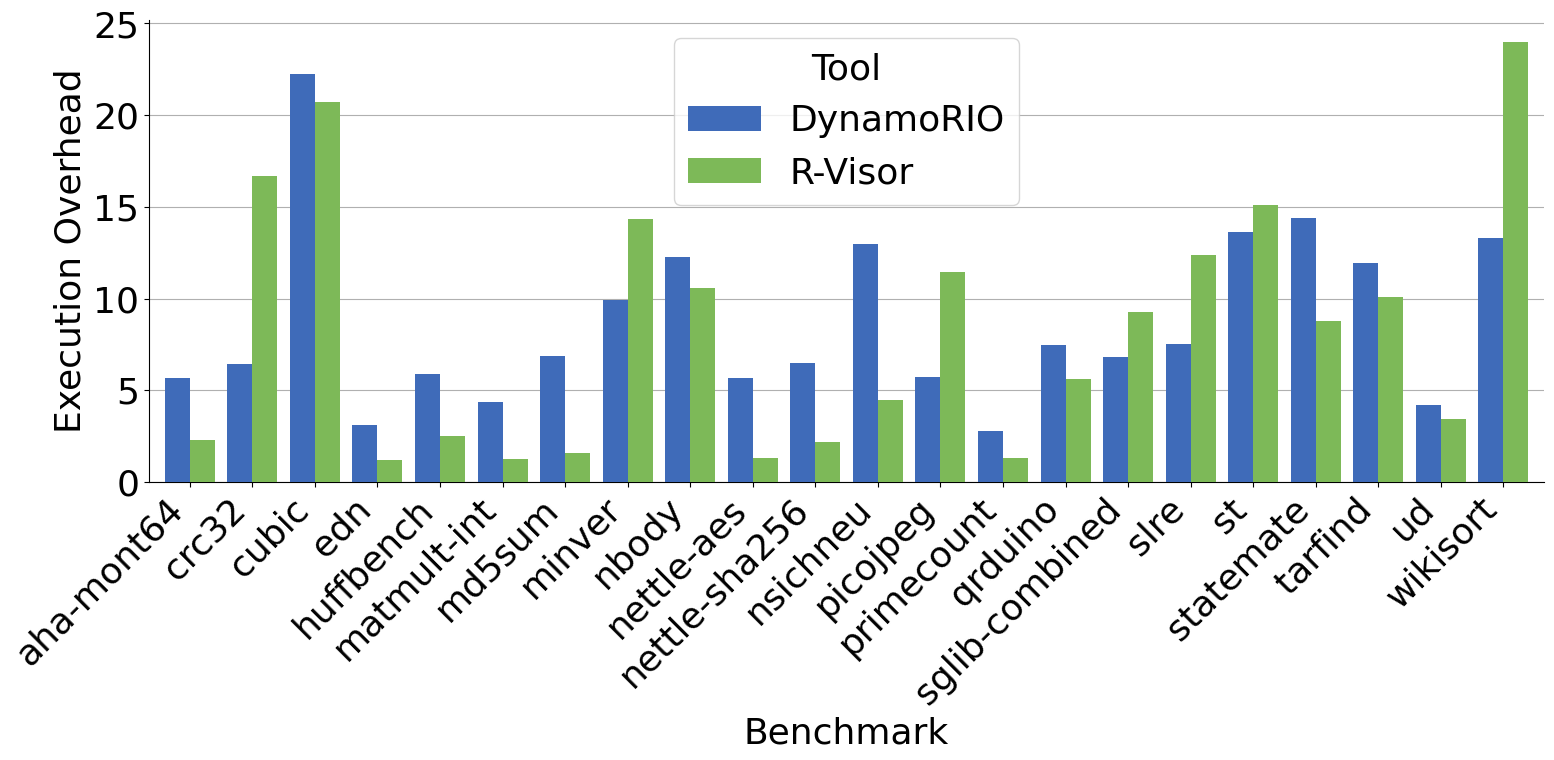

In [27]:
# Filter the dataframe for rows where Routine is 'none' and Tool is either 'dynamorio' or 'tlrvisor'
filtered_relative_df = relative_df[(relative_df['Routine'] == 'none') & (relative_df['Tool'].isin(['dynamorio', 'tlrvisor']))]

# Pivot the dataframe to get the relative elapsed time for each tool and benchmark
pivot_relative_df = filtered_relative_df.pivot(index='Benchmark', columns='Tool', values='Elapsed Time')

plt.rcParams.update({'font.size': 26})  

# Plot the pivoted dataframe
fig, ax = plt.subplots(figsize=(18, 6))
pivot_relative_df.plot(kind='bar', width=0.8, zorder=3, ax=ax, color=[rail_color, rail_plus_color])
ax.grid(axis='y', zorder=0)
ax.set_xlabel('Benchmark')
ax.set_ylabel('Execution Overhead')
ax.legend(title='Tool')

# Update legend labels
handles, labels = ax.get_legend_handles_labels()
labels = ['DynamoRIO' if label == 'dynamorio' else 'R-Visor' for label in labels]
ax.legend(handles, labels, title='Tool')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Rotate x-ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig('no_instrumentation_overhead.pdf', format='pdf', bbox_inches="tight")

plt.show()

In [24]:
# Filter the dataframe for rows where Routine is 'none' and Tool is either 'tlrvisor' or 'dynamorio'
filtered_df = df[(df['Routine'] == 'none') & (df['Tool'].isin(['tlrvisor', 'dynamorio']))]

# Pivot the dataframe to get the elapsed time for each tool and benchmark
pivot_df = filtered_df.pivot(index='Benchmark', columns='Tool', values='Elapsed Time')

# Calculate the percentage reduction in overhead for tlrvisor over dynamorio
pivot_df['Reduction Percentage'] = ((pivot_df['dynamorio'] - pivot_df['tlrvisor']) / pivot_df['dynamorio']) * 100

# Compute the average percentage reduction
average_reduction_percentage = pivot_df['Reduction Percentage'].mean()

print(f"Average percentage reduction in overhead of tlrvisor over dynamorio: {average_reduction_percentage:.2f}%")

Average percentage reduction in overhead of tlrvisor over dynamorio: 9.64%


In [25]:
# Filter the dataframe for rows where Routine is 'none' and Tool is either 'tlrvisor' or 'dynamorio'
filtered_df = df[(df['Routine'] == 'none') & (df['Tool'].isin(['tlrvisor', 'dynamorio']))]

# Pivot the dataframe to get the elapsed time for each tool and benchmark
pivot_df = filtered_df.pivot(index='Benchmark', columns='Tool', values='Elapsed Time')

# Calculate the times reduction in overhead for tlrvisor over dynamorio
pivot_df['Reduction Times'] = pivot_df['dynamorio'] / pivot_df['tlrvisor']

# Compute the average times reduction
average_reduction_times = pivot_df['Reduction Times'].mean()

print(f"Average times reduction in overhead of tlrvisor over dynamorio: {average_reduction_times:.2f} times")

Average times reduction in overhead of tlrvisor over dynamorio: 1.81 times


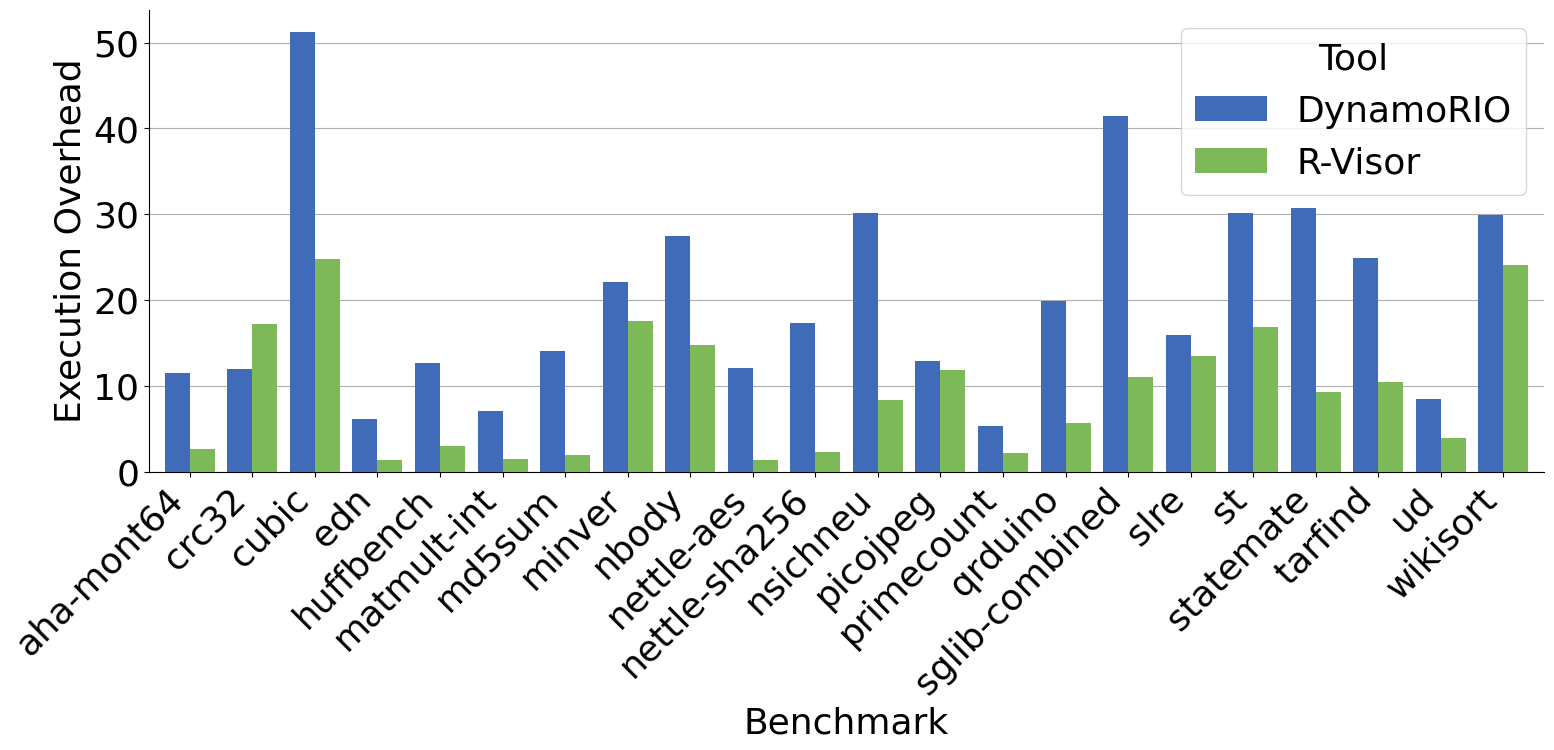

In [28]:
# Filter the dataframe for rows where Routine is 'none' and Tool is either 'dynamorio' or 'tlrvisor'
filtered_relative_df = relative_df[(relative_df['Routine'] == 'BBCount') & (relative_df['Tool'].isin(['dynamorio', 'tlrvisor']))]

# Pivot the dataframe to get the relative elapsed time for each tool and benchmark
pivot_relative_df = filtered_relative_df.pivot(index='Benchmark', columns='Tool', values='Elapsed Time')

plt.rcParams.update({'font.size': 26})  

# Plot the pivoted dataframe
fig, ax = plt.subplots(figsize=(18, 6))
pivot_relative_df.plot(kind='bar', width=0.8, zorder=3, ax=ax, color=[rail_color, rail_plus_color])
ax.grid(axis='y', zorder=0)
ax.set_xlabel('Benchmark')
ax.set_ylabel('Execution Overhead')
ax.legend(title='Tool')

# Update legend labels
handles, labels = ax.get_legend_handles_labels()
labels = ['DynamoRIO' if label == 'dynamorio' else 'R-Visor' for label in labels]
ax.legend(handles, labels, title='Tool')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Rotate x-ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig('bb_counting_overhead.pdf', format='pdf', bbox_inches="tight")

plt.show()

In [16]:
# Filter the dataframe for rows where Routine is 'none' and Tool is either 'tlrvisor' or 'dynamorio'
filtered_df = df[(df['Routine'] == 'BBCount') & (df['Tool'].isin(['tlrvisor', 'dynamorio']))]

# Pivot the dataframe to get the elapsed time for each tool and benchmark
pivot_df = filtered_df.pivot(index='Benchmark', columns='Tool', values='Elapsed Time')

# Calculate the percentage reduction in overhead for tlrvisor over dynamorio
pivot_df['Reduction Percentage'] = ((pivot_df['dynamorio'] - pivot_df['tlrvisor']) / pivot_df['dynamorio']) * 100

# Compute the average percentage reduction
average_reduction_percentage = pivot_df['Reduction Percentage'].mean()

print(f"Average percentage reduction in overhead of tlrvisor over dynamorio: {average_reduction_percentage:.2f}%")

Average percentage reduction in overhead of tlrvisor over dynamorio: 54.13%


In [17]:
# Filter the dataframe for rows where Routine is 'BBCount' and Tool is either 'tlrvisor' or 'dynamorio'
filtered_df = df[(df['Routine'] == 'BBCount') & (df['Tool'].isin(['tlrvisor', 'dynamorio']))]

# Pivot the dataframe to get the elapsed time for each tool and benchmark
pivot_df = filtered_df.pivot(index='Benchmark', columns='Tool', values='Elapsed Time')

# Calculate the times reduction in overhead for tlrvisor over dynamorio
pivot_df['Reduction Times'] = pivot_df['dynamorio'] / pivot_df['tlrvisor']

# Compute the average times reduction
average_reduction_times = pivot_df['Reduction Times'].mean()

print(f"Average times reduction in overhead of tlrvisor over dynamorio: {average_reduction_times:.2f} times")

Average times reduction in overhead of tlrvisor over dynamorio: 3.35 times


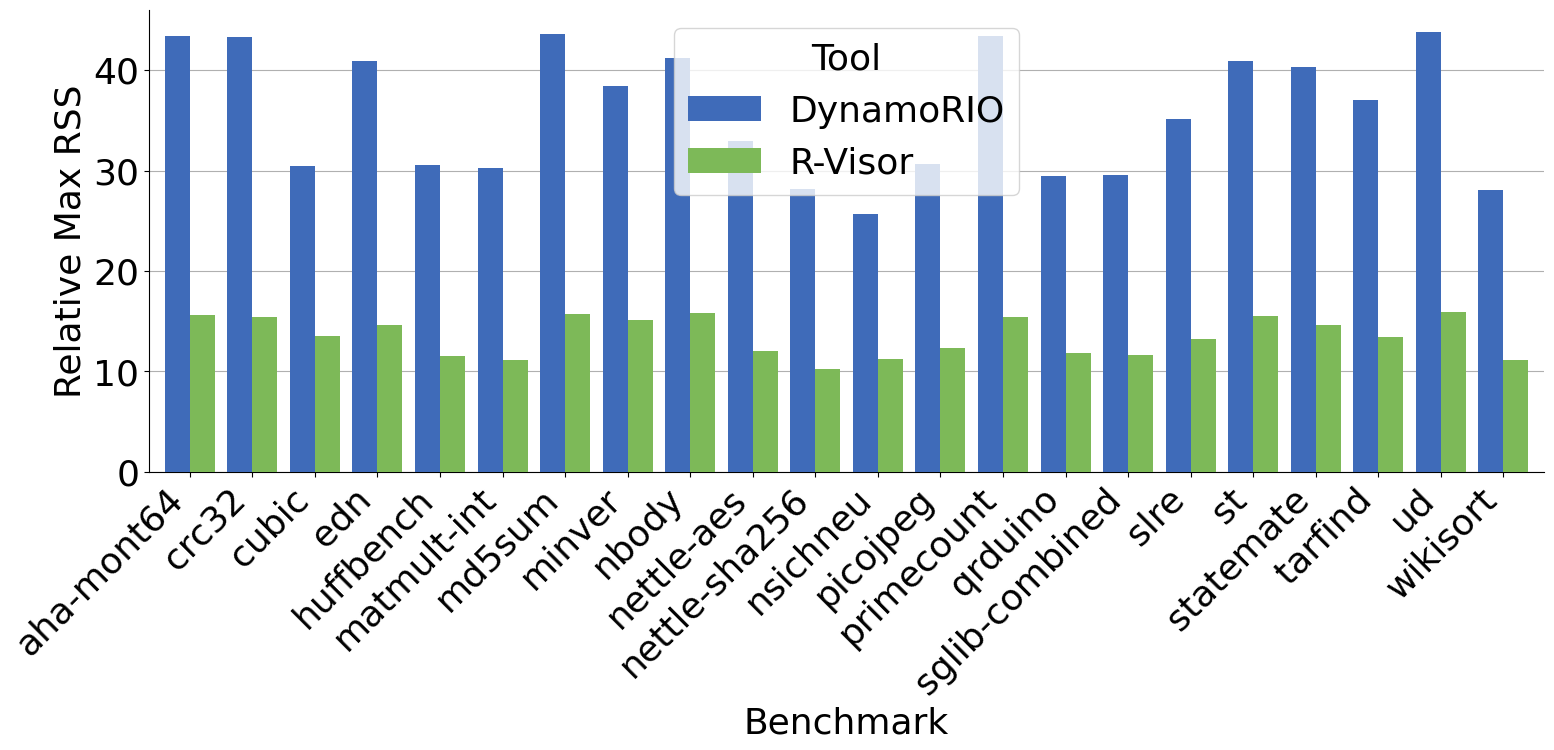

In [18]:
# Filter the dataframe for rows where Routine is 'none' and Tool is either 'dynamorio' or 'tlrvisor'
filtered_relative_df = relative_df[(relative_df['Routine'] == 'none') & (relative_df['Tool'].isin(['dynamorio', 'tlrvisor']))]

# Pivot the dataframe to get the relative elapsed time for each tool and benchmark
pivot_relative_df = filtered_relative_df.pivot(index='Benchmark', columns='Tool', values='MAX RSS')

plt.rcParams.update({'font.size': 26})  

# Plot the pivoted dataframe
fig, ax = plt.subplots(figsize=(18, 6))
pivot_relative_df.plot(kind='bar', width=0.8, zorder=3, ax=ax, color=[rail_color, rail_plus_color])
ax.grid(axis='y', zorder=0)
ax.set_xlabel('Benchmark')
ax.set_ylabel('Relative Max RSS')
ax.legend(title='Tool')

# Update legend labels
handles, labels = ax.get_legend_handles_labels()
labels = ['DynamoRIO' if label == 'dynamorio' else 'R-Visor' for label in labels]
ax.legend(handles, labels, title='Tool')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Rotate x-ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig('max_rss_overhead.pdf', format='pdf', bbox_inches="tight")

plt.show()

In [19]:
# Filter the dataframe for rows where Routine is 'none' and Tool is either 'rvisor' or 'dynamorio'
filtered_df = df[(df['Routine'] == 'none') & (df['Tool'].isin(['tlrvisor', 'dynamorio']))]

# # Pivot the dataframe to get the MAX RSS for each tool and benchmark
pivot_df = filtered_df.pivot(index='Benchmark', columns='Tool', values='MAX RSS')

# pivot_df

# # Calculate the percentage average MAX RSS of rvisor over dynamorio
percentage_avg_max_rss = ((pivot_df['dynamorio'] - pivot_df['tlrvisor']) / pivot_df['dynamorio']).mean() * 100

print(f"Percentage average MAX RSS of rvisor over dynamorio: {percentage_avg_max_rss:.2f}%")

Percentage average MAX RSS of rvisor over dynamorio: 61.98%


In [20]:
# Filter the dataframe for rows where Routine is 'none' and Tool is either 'tlrvisor' or 'dynamorio'
filtered_df = df[(df['Routine'] == 'none') & (df['Tool'].isin(['tlrvisor', 'dynamorio']))]

# Pivot the dataframe to get the MAX RSS for each tool and benchmark
pivot_df = filtered_df.pivot(index='Benchmark', columns='Tool', values='MAX RSS')

# Calculate the times reduction in MAX RSS for tlrvisor over dynamorio
pivot_df['Reduction Times'] = pivot_df['dynamorio'] / pivot_df['tlrvisor']

# Compute the average times reduction
average_reduction_times = pivot_df['Reduction Times'].mean()

print(f"Average times reduction in MAX RSS of tlrvisor over dynamorio: {average_reduction_times:.2f} times")

Average times reduction in MAX RSS of tlrvisor over dynamorio: 2.64 times
